# Rebecca's Analysis

In [1]:
import pandas as pd
import numpy as np
import project_functions1 # This is called a relative import
data = project_functions1.load_and_process("../data/processed/rec1data.csv", "../data/processed/psychdata.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4392 entries, 0 to 4553
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           4392 non-null   int64         
 1   sex          407 non-null    float64       
 2   birth        407 non-null    float64       
 3   race         407 non-null    float64       
 4   educ         407 non-null    float64       
 5   marital      407 non-null    float64       
 6   children     407 non-null    float64       
 7   occupat      407 non-null    float64       
 8   arrests      407 non-null    float64       
 9   jail         407 non-null    float64       
 10  crime01      407 non-null    float64       
 11  crime02      407 non-null    float64       
 12  crime03      407 non-null    float64       
 13  crime04      407 non-null    float64       
 14  crime05      407 non-null    float64       
 15  crime06      407 non-null    float64       
 16  crime0

In [3]:
# survival analysis libraries
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
kmf = KaplanMeierFitter()
cph = CoxPHFitter()

In [4]:
# I need another column here indicating that they all got out of treatment 
data["event"] = 1


In [7]:
# fitting model
kmf.fit(durations =  data["length"], event_observed = data["event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4392 total observations, 0 right-censored observations>

In [8]:
print(kmf.event_table)

          removed  observed  censored  entrance  at_risk
event_at                                                
0.0          1657      1657         0      4392     4392
1.0            73        73         0         0     2735
2.0            95        95         0         0     2662
3.0           110       110         0         0     2567
4.0           152       152         0         0     2457
...           ...       ...       ...       ...      ...
1852.0          1         1         0         0        5
1881.0          1         1         0         0        4
2155.0          1         1         0         0        3
2340.0          1         1         0         0        2
2590.0          1         1         0         0        1

[393 rows x 5 columns]


In [9]:
print(kmf.survival_function_)

          KM_estimate
timeline             
0.0          0.622723
1.0          0.606102
2.0          0.584472
3.0          0.559426
4.0          0.524818
...               ...
1852.0       0.000911
1881.0       0.000683
2155.0       0.000455
2340.0       0.000228
2590.0       0.000000

[393 rows x 1 columns]


<AxesSubplot:xlabel='timeline'>

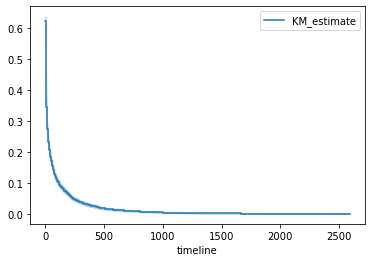

In [11]:
kmf.plot()
# This is the probability of remaining in treatment. There are no predictor 
# variables in the model yet.

In [10]:
cph_data = data[["arrests", "jail", "race", "crime_num", "length", "event"]].dropna()

In [11]:
cph.fit(cph_data, "length", event_col = "event")

<lifelines.CoxPHFitter: fitted with 407 total observations, 0 right-censored observations>

In [12]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 407 total observations, 0 right-censored observations>
             duration col = 'length'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 407
number of events observed = 407
   partial log-likelihood = -2034.39
         time fit was run = 2021-10-24 19:49:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
arrests    -0.12       0.89       0.30            -0.71             0.47                 0.49                 1.61
jail        0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
race       -0.26       0.77       0.12            -0.50            -0.01                 0.61                 0.99
crime_num   0.18       1.20       0.31            -0.43             0.79                 0.65                 2.21

              z    p   -log2(p)
covariate                      
arrests   -0.38 0.70       0.51
jail       0.40 0.69       0.53
race      -2.06 0.04       4.66
crime_num  0.58 0.56       0.83
---
Concordance = 0.56
Partial AIC = 4076.77
log-likelihood ratio test = 16.25 on 4 df
-log2(p) of ll-ratio test = 8.53

Number of arrests significantly predicts length of psychiatric treatment. This coefficient is positive though - very strange! More arrests mean higher likelihood of psychiatric treatment ending (shorter treatment duration). 

Time in jail doesn't significantly predict length of psychiatric treatment.

Race predicts length of psychiatric treatment, but this is a categorical variable so we will have to probe further.

Number of crimes doesn't significantly predict length of psychiatric treatment.

In [49]:
# looking for peolpe with highest and lowest values of arrests and jail variables
print(np.argmax(data["arrests"]))
print(np.argmin(data["arrests"]))
print(data["arrests"][[275,59]])

275
59
275    8.0
59     3.0
Name: arrests, dtype: float64


<AxesSubplot:>

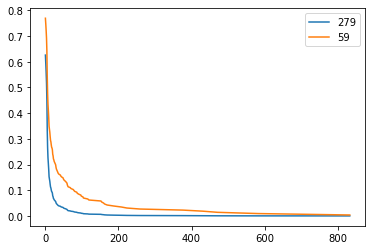

In [47]:
d_data = data.iloc[[275,59],:]
cph.predict_survival_function(d_data).plot()

Participant 279 (8 arrests) is likely to be in psychiatric teratemnt for a shorter amount of time than participant 59 (3 arrests). This is very strange and the complete opposite of what I would have expected. At the same time, both have a very high probability of getting out of treatment very quickly (within 5 days). 

In [74]:
# Looking for participants of different races with the same number of arrests
data["arrests"].median()
screen = [(data["arrests"] == 7) & (data["race"] == 1)]
print(np.nonzero(screen))
screen = [(data["arrests"] == 7) & (data["race"] == 2)]
print(np.nonzero(screen))


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 274]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0]), array([ 74,  75,  76,  77,  78, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 399, 400, 401]))


<AxesSubplot:>

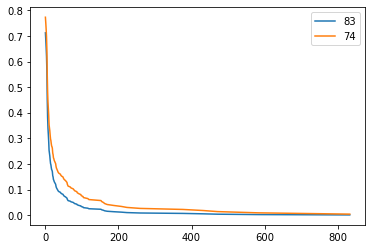

In [75]:
d_data = data.iloc[[83,74],:]
cph.predict_survival_function(d_data).plot()

White prisoners (race = 1) are more likely to get out of psychiatric treatment early than black prisoners (race = 2).

Is there an interaction between arrests and race?

In [85]:
# Looking for participants of different races with the same number of arrests - higher and lower values this time
screen = [(data["arrests"] == 3) & (data["race"] == 1)]
print(np.nonzero(screen))
screen = [(data["arrests"] == 3) & (data["race"] == 2)]
print(np.nonzero(screen))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 59,  60,  61,  73, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 293,
       294, 295, 296, 297, 313, 314, 315, 316, 317, 318, 319, 320, 321,
       322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334,
       335, 336, 337, 338, 339, 340, 341, 342, 343]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 79,  80,  81,  82, 357, 358, 359, 360, 361, 362, 363, 364, 365]))


<AxesSubplot:>

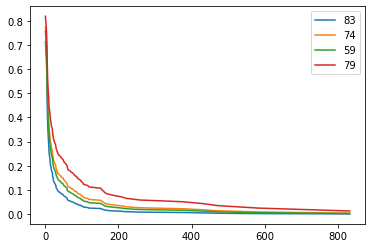

In [86]:
d_data = data.iloc[[83,74,59,79],:]
cph.predict_survival_function(d_data).plot()

83: White, median (7) arrests
74: Black, median (7) arrests
59: White, low (3) arrests
79: Black, low (3) arrests

The difference within race between low and median arrests is larger for Black prisoners. Having fewer arrests is associated with longer treatment time for Black prisoners to a greater extent than it is for White prisoners. 

How do arrest values differ by race?

In [92]:
White = data[data["race"] == 1]
White["arrests"].describe()

count    303.000000
mean       6.339934
std        2.453533
min        3.000000
25%        4.000000
50%        7.000000
75%        8.000000
max       10.000000
Name: arrests, dtype: float64

In [94]:
Black = data[data["race"] == 2]
Black["arrests"].describe()

count    104.000000
mean       7.038462
std        3.785314
min        3.000000
25%        4.000000
50%        5.000000
75%        8.000000
max       14.000000
Name: arrests, dtype: float64

array([[<AxesSubplot:title={'center':'arrests'}>]], dtype=object)

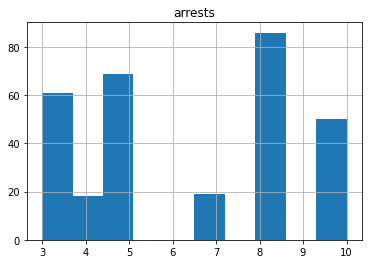

In [95]:
White.hist(column = "arrests")

array([[<AxesSubplot:title={'center':'arrests'}>]], dtype=object)

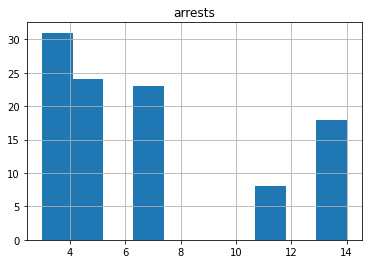

In [96]:
Black.hist(column = "arrests")

Number of arrests looks fairly similar for the two racial groups.